In [1]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from scipy.fftpack import fft

import gc
%matplotlib inline

In [2]:
%time
train_df = pd.read_csv(os.path.join("../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 10 µs


In [3]:
train_df.shape

(629145480, 2)

In [4]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [5]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [9]:
def add_statistics(seg_id,feat_name,X,xc,ws=""):
    X[seg_id,feat_name + "_mean"+ws] = xc.mean()
    X[seg_id,feat_name + "_var"+ws] = xc.var()
    X[seg_id,feat_name + "_min"+ws] = xc.min()
    X[seg_id,feat_name + "_max"+ws] = xc.max()
    X[seg_id,feat_name + "_kurt"+ws] = xc.kurt()
    X[seg_id,feat_name + "_skew"+ws] = xc.skew()
    
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]
    
    fftxc = fft(xc)
    X.loc[seg_id,"fft_mean"] = np.abs(fftxc).mean()
    X.loc[seg_id,"fft_max"] = np.abs(fftxc).max()
    X.loc[seg_id,"fft_min"] = np.abs(fftxc).min()
    
    X.loc[seg_id,"25_quantile"] = xc.quantile(0.25)
    X.loc[seg_id,"50_quantile"] = xc.quantile(0.50)
    X.loc[seg_id,"75_quantile"] = xc.quantile(0.75)
    X.loc[seg_id,"1_quantile"] = xc.quantile(0.01)
    X.loc[seg_id,"99_quantile"] = xc.quantile(0.99)
    
    xc_splitted = np.array_split(xc, 4)

    add_statistics(seg_id,"1_part",X,xc_splitted[0])
    add_statistics(seg_id,"2_part",X,xc_splitted[1])
    add_statistics(seg_id,"3_part",X,xc_splitted[2])
    add_statistics(seg_id,"4_part",X,xc_splitted[3])

    add_statistics(seg_id,"seg",X,xc)
  
    
    window_sizes = [20,100,500,1000]
    for window_size in window_sizes:
        xc_rolled = xc.rolling(window_size)
        xc_rolled_mean = xc_rolled.mean().dropna()
        xc_rolled_var = xc_rolled.var().dropna()
        ws = str(window_size)
        
        add_statistics(seg_id,"rollingMean",X,xc_rolled_mean,ws=ws)
        add_statistics(seg_id,"rollingVar",X,xc_rolled_var,ws=ws)

In [10]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    

KeyboardInterrupt: 

In [95]:
def load_test():
    signals = []
    segment_names = [file for file in os.listdir("../input") if file.startswith("seg")]
    test_df = pd.DataFrame(index=segment_names, dtype=np.float64)
    test_df.index = test_df.index.str[:-4]
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("../input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)
    return test_df
test_df = load_test()

In [104]:
train_X.head()

,fft_mean,fft_max,fft_min,25_quantile,50_quantile,75_quantile,1_quantile,99_quantile,1_part_mean,2_part_mean,...,rolling_min_1000,rolling_skew_1000,rolling_kurt_1000,rolling_var_1000,rollingvar_mean_1000,rollingvar_max_1000,rollingvar_min_1000,rollingvar_skew_1000,rollingvar_kurt_1000,rollingvar_var_1000
0,1251.532473,732617.0,1.677194,3.0,5.0,7.0,-8.0,18.0,4.999120,4.945067,...,3.896,-0.362100,-0.011405,0.087448,26.063646,962.826457,6.434506,9.821299,109.428069,4805.098436
1,1460.006819,708865.0,2.454891,2.0,5.0,7.0,-11.0,21.0,4.658240,4.736693,...,3.412,-0.037063,-0.401352,0.053633,43.645550,1493.298242,6.297353,7.368732,57.264722,23057.160825
2,1516.841892,735959.0,2.389381,2.0,5.0,7.0,-15.0,26.0,4.688747,4.815120,...,4.055,-0.151766,0.025022,0.071296,48.787910,1247.989590,6.677597,5.988294,46.496248,12929.013668
3,1494.430080,735336.0,2.524297,2.0,5.0,7.0,-12.0,22.0,4.908080,4.745120,...,3.722,-0.205127,-0.505194,0.071129,48.147716,2788.436956,6.371327,10.439095,119.038796,43136.235776
4,1566.780849,736308.0,3.839907,2.0,5.0,7.0,-15.0,26.0,4.897360,4.918240,...,3.918,0.233304,0.195879,0.051987,53.412710,2073.202978,6.490842,7.081533,58.718557,32894.369930


In [105]:
test_df.head()

,fft_mean,fft_max,fft_min,25_quantile,50_quantile,75_quantile,1_quantile,99_quantile,1_part_mean,2_part_mean,...,rolling_min_1000,rolling_skew_1000,rolling_kurt_1000,rolling_var_1000,rollingvar_mean_1000,rollingvar_max_1000,rollingvar_min_1000,rollingvar_skew_1000,rollingvar_kurt_1000,rollingvar_var_1000
seg_00030f,1254.037936,673767.0,5.404037,2.0,4.0,7.0,-8.0,18.0,4.449120,4.539947,...,3.774,-0.161726,0.061229,0.053774,23.909286,610.942286,6.203804,8.414273,85.781704,2409.144787
seg_0012b5,1392.755787,625673.0,1.922947,2.0,4.0,7.0,-12.0,20.0,4.009760,4.151040,...,3.342,0.010131,-0.085346,0.053321,35.210685,880.920857,6.456335,5.875881,38.394511,8854.005351
seg_00184e,1516.299674,691539.0,1.567219,2.0,5.0,7.0,-11.0,20.0,4.498987,4.740747,...,3.544,-0.210958,-0.411439,0.061118,48.515394,2816.349781,6.262293,9.490951,100.633434,47957.179384
seg_003339,1127.373974,679721.0,3.308495,3.0,5.0,7.0,-5.0,14.0,4.463947,4.711040,...,3.889,0.179065,-0.116018,0.050584,16.958824,519.987812,5.995971,8.852743,91.502969,1684.865024
seg_0042cc,1340.070052,619251.0,4.718620,2.0,4.0,6.0,-10.0,19.0,4.240587,4.224160,...,3.357,0.111537,0.098487,0.075090,33.740549,1156.055656,6.337473,7.634272,67.724445,11187.707879


In [106]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [107]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'min_data_in_leaf': 10, 
    'metric': {'l2', 'l1'},
    'num_leaves': 45,
    'max_depth':4,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'metric':'mae'
}

In [108]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(train_X.shape[0])

for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train)
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_val,y_val)], 
              verbose=1000,
              early_stopping_rounds=1000)
    
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    features_importance["importance"] += model.feature_importances_
    predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_) 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.26576	valid_1's l1: 2.36239
[2000]	training's l1: 2.06007	valid_1's l1: 2.23302
[3000]	training's l1: 1.96958	valid_1's l1: 2.20599
[4000]	training's l1: 1.90831	valid_1's l1: 2.20054
[5000]	training's l1: 1.85691	valid_1's l1: 2.19887
[6000]	training's l1: 1.81193	valid_1's l1: 2.19891
Early stopping, best iteration is:
[5695]	training's l1: 1.82596	valid_1's l1: 2.19785
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.25891	valid_1's l1: 2.35778
[2000]	training's l1: 2.05184	valid_1's l1: 2.23484
[3000]	training's l1: 1.9588	valid_1's l1: 2.20655
[4000]	training's l1: 1.89393	valid_1's l1: 2.20047
Early stopping, best iteration is:
[3617]	training's l1: 1.91685	valid_1's l1: 2.20013
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.26536	valid_1's l1: 2.3961
[2000]	training's l1: 2.06506	valid_1's l1: 2.23513
[3000]	train

In [109]:
mean_absolute_error(train_y,oof)

2.172469815550253

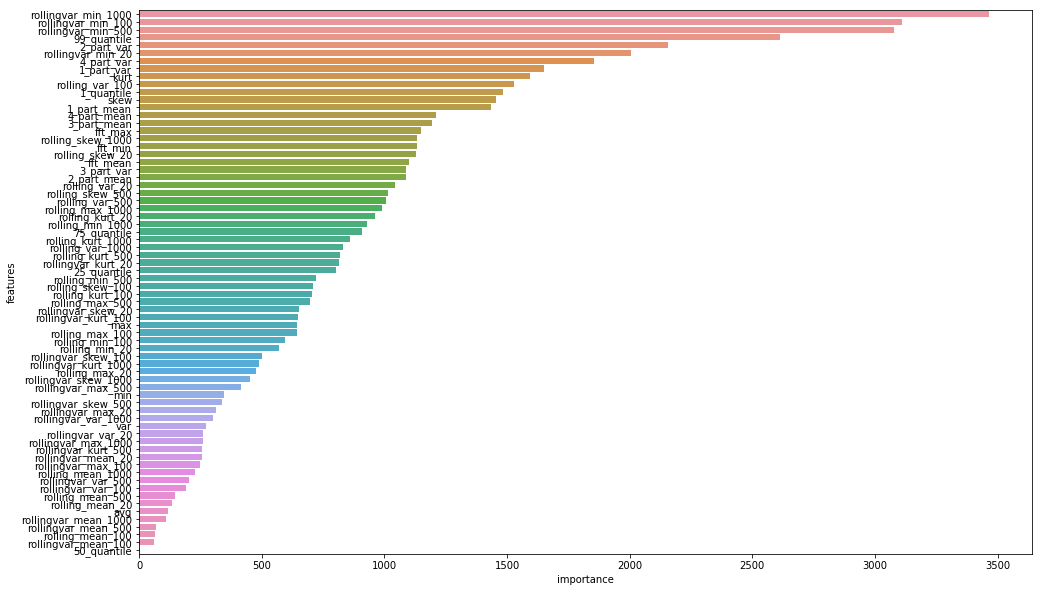

In [110]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5

plt.figure(figsize=(16,10))
ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))


In [111]:
predictions.to_csv("../submissions/submission_lgb_quantiles_segments.csv",index=False)